# Dimensionality reduction on trial features

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [37]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from scipy import stats
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.utils import resample

# Image processing
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import cv2

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [4]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# states_file = pd.read_parquet(data_path+'states_trial_type_5k_5_09-24-2025')
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')


In [5]:
## Get sequences per trial epoch
# results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
# filename = str(results_path + 'epoch_sequences_10_03-11-2025')
filename = str(data_path + 'all_sequences_5k_09-24-2025')
filename = str(data_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)
# all_sequences = pickle.load(open(filename, 'rb'))

design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
## Get timing data


# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge

merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

## Get sequences per trial

In [6]:
all_sequences['session'] = all_sequences['sample'].str[:36]

In [7]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

## Separate states per variable (one-hot encoding)

In [8]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

In [9]:
final_matrix = binarized.copy()

([<matplotlib.axis.XTick at 0x7f94b10ab3a0>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640'),
  Text(800, 0, '800'),
  Text(960, 0, '960'),
  Text(1120, 0, '1120')])

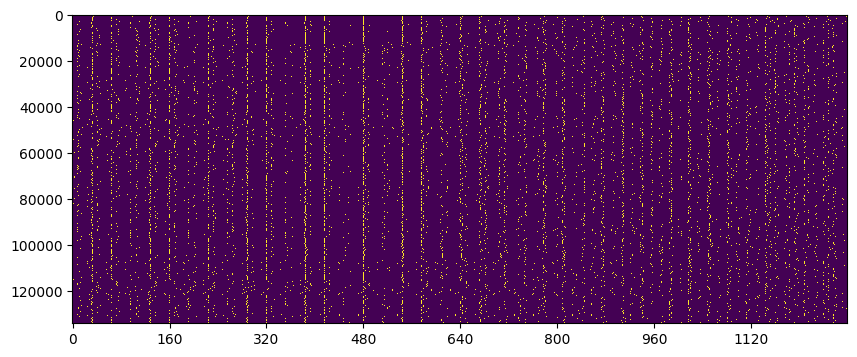

In [10]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(final_matrix), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

# PCA

In [284]:
n_components = 500
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
# standardized_X = scaler.fit_transform(final_matrix)
# X_pca = pca.fit_transform(standardized_X)
X_pca = pca.fit_transform(final_matrix)

Text(0.5, 1.0, 'Explained Variance by PCA')

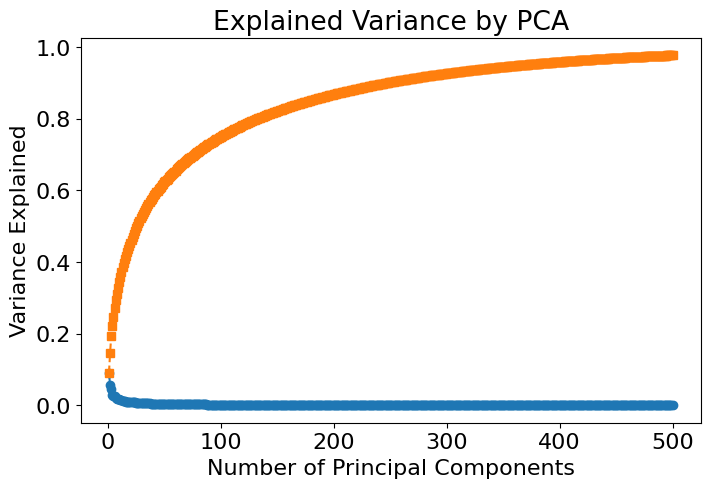

In [285]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

# UMAP

In [288]:
ori_X = X_pca.copy()
# ori_X = final_matrix.copy()

In [289]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

embedding = reducer.fit_transform(ori_X)
# embedding = reducer.fit_transform(X_pca)
embedding.shape

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(133815, 2)

In [290]:
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.segmentation import find_boundaries
from skimage.morphology import disk


In [291]:
def plot_kde(X_embedded, kernel, xmin, xmax, ymin, ymax, res):
    X, Y = np.mgrid[xmin:xmax:res, ymin:ymax:res]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
            extent=[xmin, xmax, ymin, ymax], aspect='auto')
    ax.plot(X_embedded[:, 0], X_embedded[:, 1], 'k.', 
            markersize=.1, alpha=.1)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

    plt.show()

    return Z

def points_to_pixels(points, xmin, xmax, ymin, ymax, nx, ny):
    px = ((points[:, 0] - xmin) / (xmax - xmin) * (nx - 1)).astype(int)
    py = ((points[:, 1] - ymin) / (ymax - ymin) * (ny - 1)).astype(int)

    px = np.clip(px, 0, nx - 1)
    py = np.clip(py, 0, ny - 1)

    return px, py

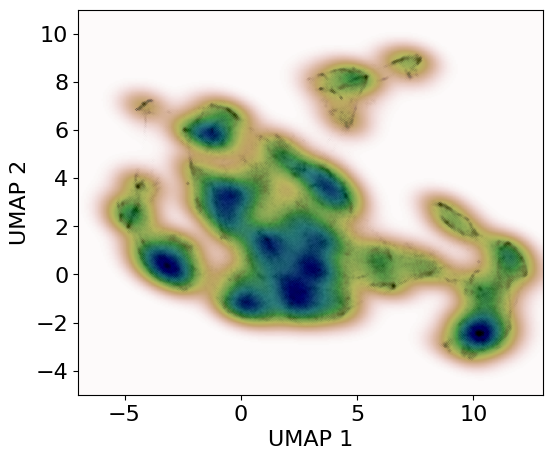

In [300]:
""" Perform Gaussian kde """
values = embedding.T.copy()
kernel = stats.gaussian_kde(values)

xmin = -7
xmax = 13
ymin=-5
ymax=11
Z = plot_kde(embedding, kernel, xmin, xmax, ymin, ymax, res=300j)

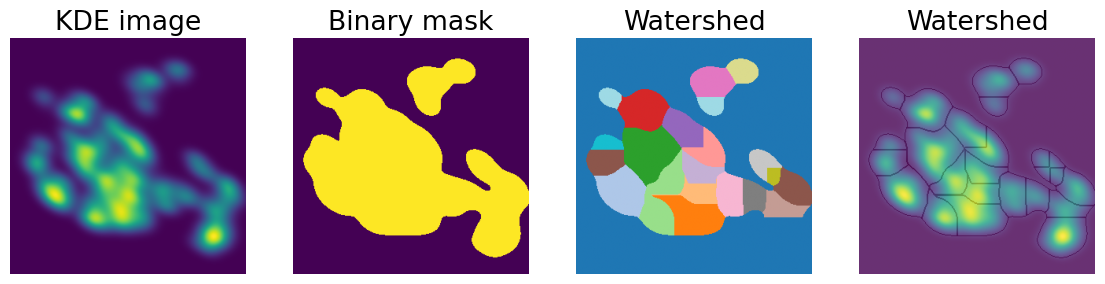

In [308]:
image = Z.copy()
# image = gaussian(image, sigma=.5)

binary = image > np.percentile(image, 60)
binary = ndi.binary_fill_holes(binary)

coords = peak_local_max(
    image,
    footprint=disk(1),
    min_distance=1,
    labels=binary)
markers = np.zeros(image.shape, dtype=int)
markers[tuple(coords.T)] = np.arange(1, len(coords) + 1)

labels = watershed(-image, markers, mask=binary)

boundaries = find_boundaries(labels, mode="outer")

fig, ax = plt.subplots(1, 4, figsize=(14, 4))
ax[0].imshow(np.rot90(Z))
ax[0].set_title("KDE image")
ax[1].imshow(np.rot90(binary))
ax[1].set_title("Binary mask")
ax[2].imshow(np.rot90(labels), cmap="tab20")
ax[2].set_title("Watershed")
ax[3].imshow(np.rot90(image))
ax[3].imshow(np.rot90(boundaries), cmap="Reds", alpha=0.2)
ax[3].set_title("Watershed")
for a in ax:
    a.axis("off")
plt.show()

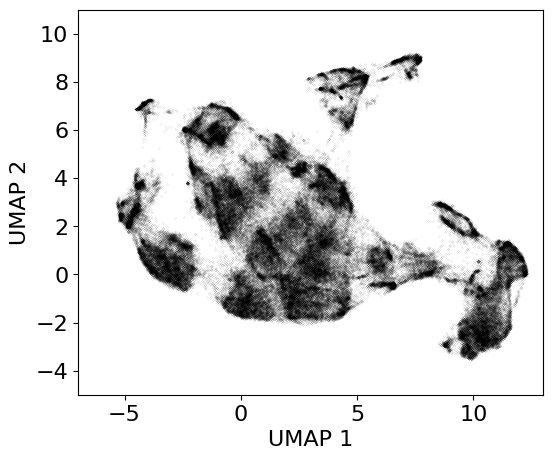

In [304]:
fig, ax = plt.subplots(figsize=(6, 5))
# ax.imshow(np.rot90(boundaries), cmap=plt.cm.gist_earth_r,
#         extent=[xmin, xmax, ymin, ymax], aspect='auto')
ax.plot(embedding[:, 0], embedding[:, 1], 'k.', markersize=.1)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.show()

## Back to UMAP embedding space

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_23964/3911416887.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


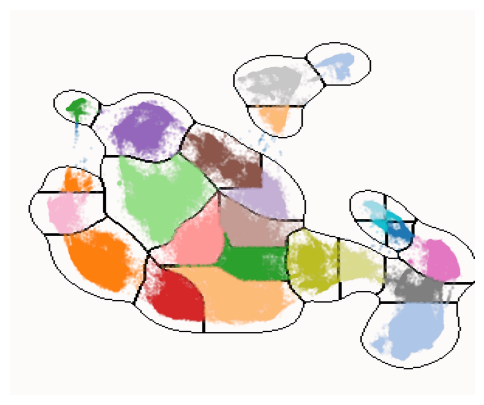

In [309]:
nx, ny = Z.shape
px, py = points_to_pixels(
    embedding,
    xmin, xmax,
    ymin, ymax,
    labels.shape[0],
    labels.shape[1])

point_labels = labels[px, py]
# point_labels[np.where(point_labels==0)] = np.nan

# Plot
plt.figure(figsize=(6, 5))
cmap = plt.get_cmap("tab20")
clusters = np.unique(point_labels)
color_dict = {
    k: cmap(k % cmap.N)   # exact tab20 color
    for k in clusters}
scatter_colors = np.array([color_dict[k] for k in point_labels])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    color=scatter_colors, #c=point_labels,
    cmap="tab20",
    s=2, alpha=.1)
plt.imshow(np.rot90(boundaries), cmap=plt.cm.gist_earth_r,
        extent=[xmin, xmax, ymin, ymax], aspect='auto')
plt.axis("off")
plt.show()


24


(array([  112., 10292., 10839., 13966.,  7314., 15307.,  7621.,  7745.,
         8342.,  5105.,  7046.,  6604.,  4715.,  3778.,  3619.,  4539.,
         5231.,  2622.,   934.,  1188.,  1111.,  2087.,  1333.,  1352.,
         1013.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <BarContainer object of 25 artists>)

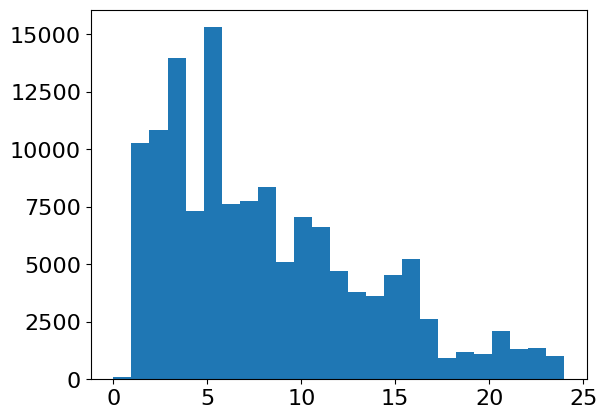

In [310]:
n_clusters = len(np.unique(point_labels))-1
print(n_clusters)
plt.hist(point_labels, bins=n_clusters+1)

In [313]:
design_df['trial_cluster'] = point_labels
design_df.loc[design_df['trial_cluster']==0, 'trial_cluster'] = np.nan



In [314]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# np.save(data_path+'10_trial_cluster', design_df)
design_df.to_parquet(data_path+str(n_clusters)+'_trial_waterclust',compression='gzip') 

In [228]:
merged_df = merged_df[['sample', 'trial_type', 'mouse_name', 'Choice', 'ITI', 'Pre-quiescence',
       'Quiescence', 'feedback', 'choice', 'block', 'contrast', 'side',
       'session', 'trial_id', 'elongation', 'response', 'reaction',
       'response_qt', 'elongation_qt']]

In [229]:
merged_df = merged_df.merge(design_df[['sample', 'mouse_name', 'session', 'trial_cluster']], on=['sample', 'mouse_name', 'session'])

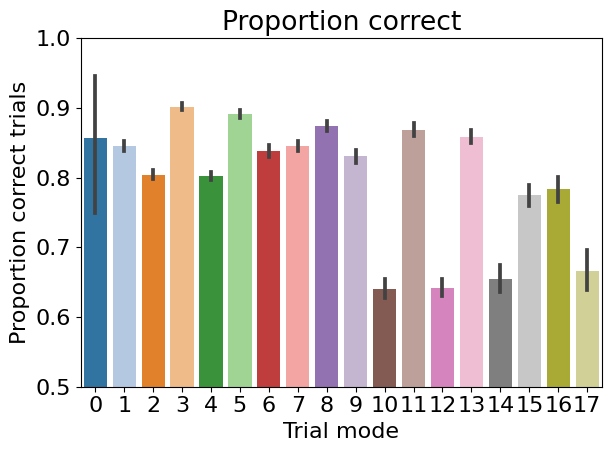

In [256]:
sns.barplot(x='trial_cluster', y='feedback', data=merged_df, palette=color_dict)
plt.title('Proportion correct')
plt.ylabel('Proportion correct trials')
plt.ylim([0.5,1])
plt.xlabel('Trial mode')
plt.tight_layout()
plt.show()

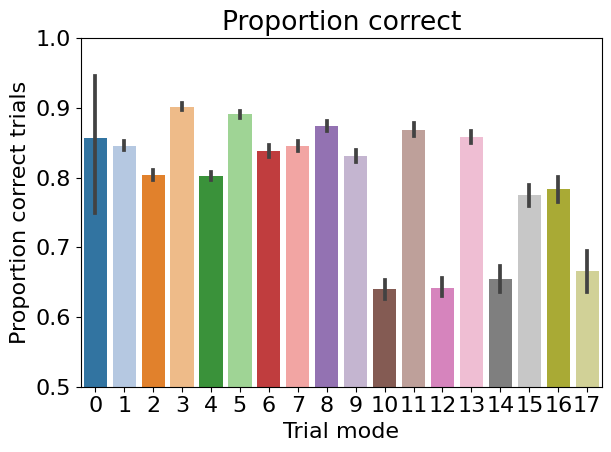

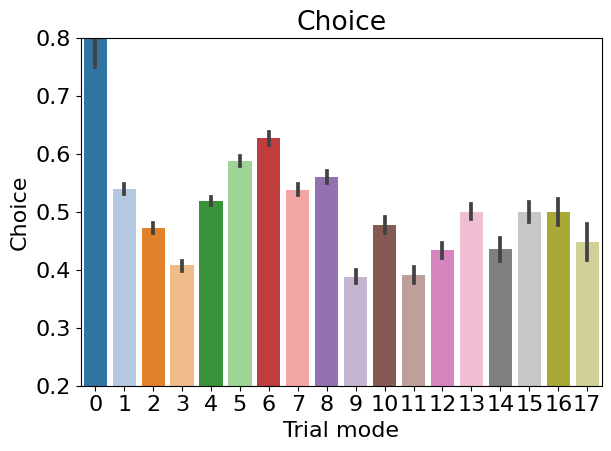

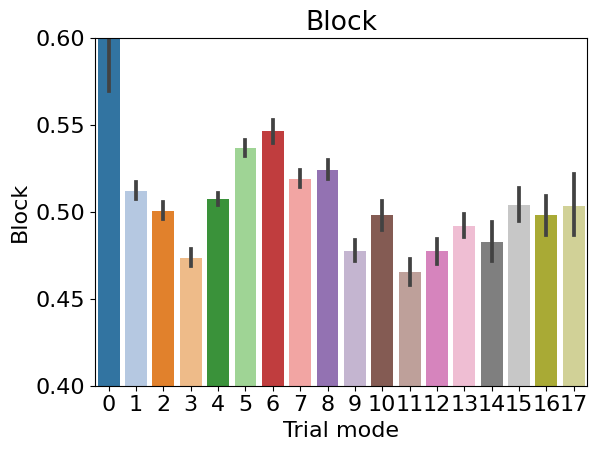

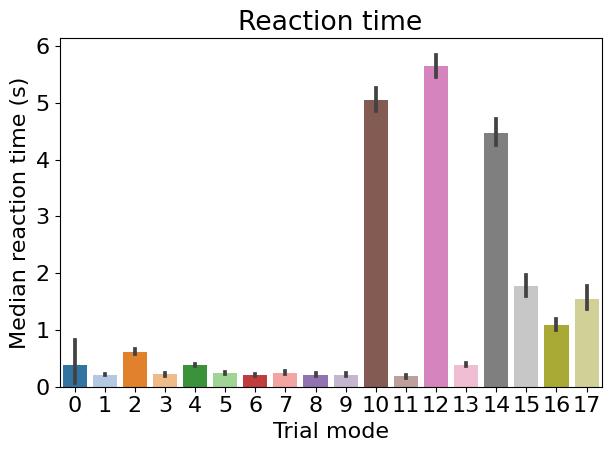

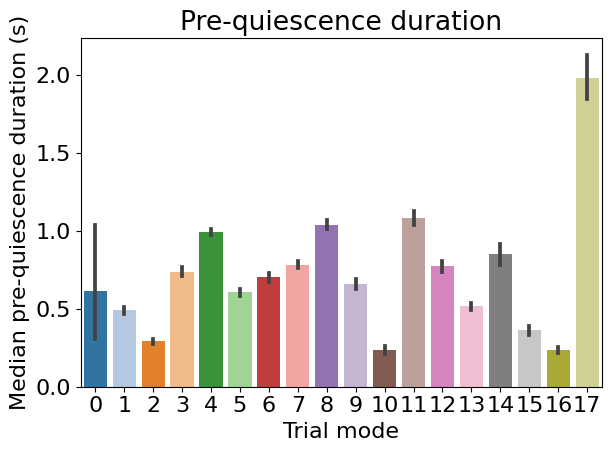

In [257]:
# save_path = prefix + 'representation_learning_variability/Exported figures/COSYNE/'
plt.rcParams.update({'font.size': 16})

sns.barplot(x='trial_cluster', y='feedback', data=merged_df, palette=color_dict)
plt.title('Proportion correct')
plt.ylabel('Proportion correct trials')
plt.ylim([0.5,1])
plt.xlabel('Trial mode')
plt.tight_layout()
plt.show()

sns.barplot(x='trial_cluster', y='choice', data=merged_df, palette=color_dict)
plt.ylabel('Choice')
plt.title('Choice')
plt.ylim([0.2,.8])
plt.tight_layout()
plt.xlabel('Trial mode')
plt.show()

sns.barplot(x='trial_cluster', y='block', data=merged_df, palette=color_dict)
plt.ylabel('Block')
plt.title('Block')
plt.ylim([0.4,.6])
plt.tight_layout()
plt.xlabel('Trial mode')
plt.show()


sns.barplot(x='trial_cluster', y='reaction', data=merged_df, palette=color_dict)
plt.ylabel('Median reaction time (s)')
plt.title('Reaction time')
plt.xlabel('Trial mode')
plt.tight_layout()
plt.show()

sns.barplot(x='trial_cluster', y='elongation', data=merged_df, palette=color_dict)
plt.ylabel('Median pre-quiescence duration (s)')
plt.title('Pre-quiescence duration')
plt.xlabel('Trial mode')
plt.tight_layout()
plt.show()


# sns.barplot(x='trial_cluster', y='feedback', hue='choice', data=merged_df, palette=palette)
# plt.title('Proportion correct')
# plt.ylabel('Proportion correct trials')
# plt.ylim([0.5,1])
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='reaction', hue='choice', data=merged_df, palette=palette)
# plt.ylabel('Median reaction time (s)')
# plt.title('Reaction time')
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='elongation', hue='choice', data=merged_df, palette=palette)
# plt.ylabel('Median pre-quiescence duration (s)')
# plt.title('Pre-quiescence duration')
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='reaction', hue='prev_feedback', data=merged_df)
# plt.ylabel('Median reaction time (s)')
# plt.title('Reaction time')
# plt.xlabel('Trial mode')
# plt.show()

# sns.barplot(x='trial_cluster', y='elongation', hue='prev_feedback', data=merged_df)
# plt.ylabel('Median pre-quiescence duration (s)')
# plt.title('Pre-quiescence duration')
# plt.xlabel('Trial mode')
# plt.show()


# sns.barplot(x='cluster', y='choice', data=trial_clusters, palette=palette)
# plt.savefig(save_path+'trial_cluster_choice.svg', format="svg")
# plt.show()
# sns.barplot(x='cluster', y='block', data=trial_clusters, palette=palette)
# plt.savefig(save_path+'trial_cluster_block.svg', format="svg")
# plt.show()
# sns.barplot(x='cluster', y='contrast', data=trial_clusters, palette=palette)
# plt.savefig(save_path+'trial_cluster_contrast.svg', format="svg")
# plt.show()

# sns.barplot(x='cluster', y='prev_feedback', data=merged_df, palette=palette)
# plt.ylabel('Previous trial accuracy')
# plt.xlabel('Trial mode')

In [ ]:
# data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# merged_df.to_parquet(data_path+'trial_clusters_5', compression='gzip')